In [48]:
import pandas as pd
import numpy as np

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")
plt.rcdefaults()
plt.style.use('default')

%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime

## ARIMA/HWES
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

import warnings
warnings.filterwarnings('ignore')

In [76]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    

company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Exploratory Data Analysis

In [71]:
AAPL = AAPL.drop(columns=['company_name'])
AAPL.index = pd.to_datetime(AAPL.index, format='%d/%m/%Y')

<AxesSubplot: >

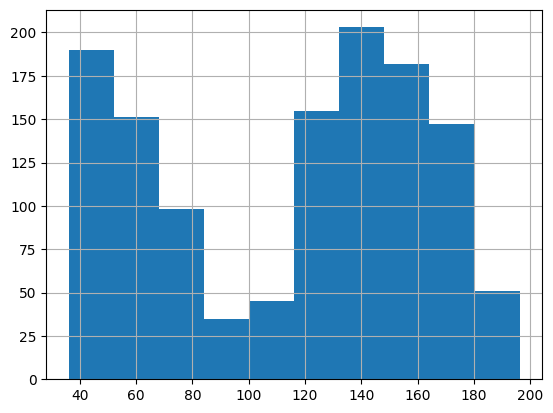

In [72]:
AAPL['Open'].hist()

<AxesSubplot: >

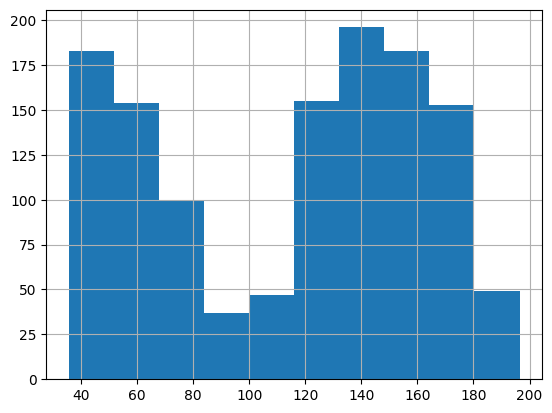

In [73]:
AAPL['Close'].hist()

## Decomposition Plot

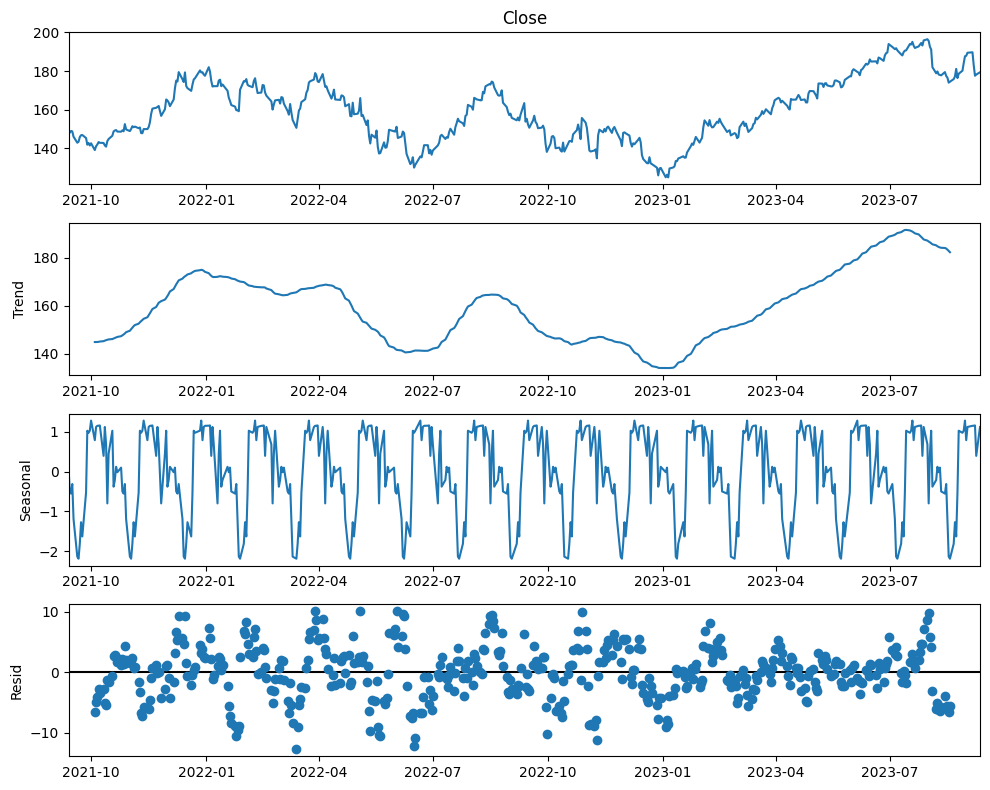

In [80]:
## apple stock decomposition plot
result = seasonal_decompose(AAPL['Close'], model='additive', period=30)
with mp.rc_context():
    mp.rc("figure", figsize=(10,8))
    result.plot()
    plt.show()

## Seasonal ACF & PACF Plots

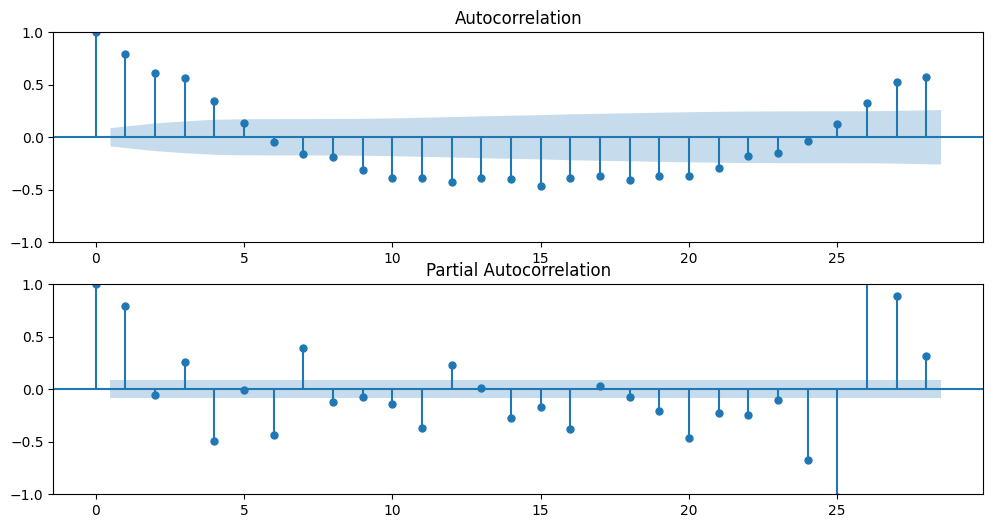

In [81]:
## AAPL seasonal ACF & PACF plots
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(result.seasonal, ax=ax[0])
plot_pacf(result.seasonal, ax=ax[1])
plt.show()

## Check For Stationarity

In [82]:
## identify min and max index in the dataframe
index = AAPL.index
mindex = index.min()
maxdex = index.max()

print("min index: " + str(mindex))
print("max index: " + str(maxdex))

min index: 2021-09-13 00:00:00
max index: 2023-09-11 00:00:00


In [84]:
AAPL1 = AAPL[AAPL.index<='2022-09-12']
AAPL2 = AAPL[AAPL.index>'2022-09-12']
AAPL1Mean = AAPL1['Close'].mean()
AAPL2Mean = AAPL2['Close'].mean()
AAPL1Var = AAPL1['Close'].var()
AAPL2Var = AAPL2['Close'].var()
print(f'Group 1 Mean: {AAPL1Mean} | Group 2 Mean: {AAPL2Mean}')
print(f'Group 1 Var: {AAPL1Var} | Group 2 Var: {AAPL2Var}')

Group 1 Mean: 158.3339685712542 | Group 2 Mean: 160.7158396911621
Group 1 Var: 157.76469897850276 | Group 2 Var: 362.7528904330012


In [85]:
## conduct augmented dicky fuller test
pval = adfuller(AAPL['Close'])
print('p-val of AAPL Close: %f' % pval[1])

p-val of AAPL Close: 0.338034


## First-Order Differential

In [90]:
# First-order differencing
stationary = AAPL.diff().dropna()

In [94]:
## conduct augmented dicky fuller test
pval = adfuller(stationary['Close'])
print('p-val of First-Order Derived AAPL Close: %f' % pval[1])

p-val of First-Order Derived AAPL Close: 0.000000


## p, d, q Values

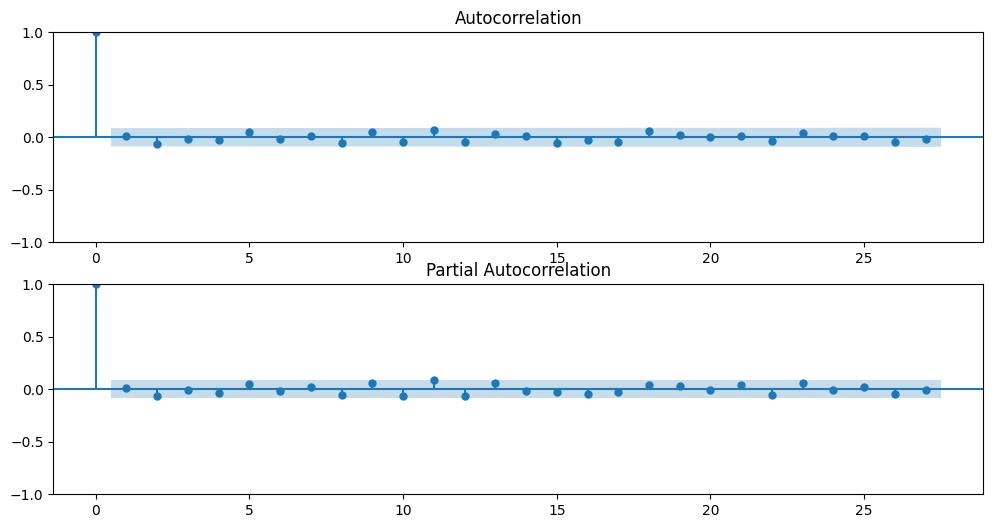

In [96]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))
plot_acf(stationary['Close'], ax=ax[0])
plot_pacf(stationary['Close'], ax=ax[1])
plt.show()

## Seasonal Auto Regressive Integrated Moving Average with eXogenous Regressors (SARIMAX)

In [98]:
exog = stationary[['Open', 'High', 'Low', 'Volume']]

In [121]:
arima_model = SARIMAX(stationary['Close'], order=(1, 1, 1),
                      seasonal_order=(1, 1, 1, 7), trend='n').fit()

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             Close   No. Observations:                  501
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -1250.586
Date:                           Tue, 12 Sep 2023   AIC                           2511.172
Time:                                   12:40:36   BIC                           2532.174
Sample:                                        0   HQIC                          2519.418
                                           - 501                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0166      0.044      0.378      0.706      -0.070       0.103
ma.L1         -0.9997      0.483     -2.070      0.038      -1.946      -0.053
ar.S.L7        0.0256      0.049      0.526      0.599      -0.070       0.121
ma.S.L7       -0.9998      3.103     -0.322      0.747      -7.081       5.082
sigma2         8.5961     26.921      0.319      0.749     -44.167      61.359
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                29.89
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [122]:
pred = arima_model.get_prediction().predicted_mean

mae = mean_absolute_error(stationary['Close'], pred)
mape = mean_absolute_percentage_error(stationary['Close'], pred)
mse = mean_squared_error(stationary['Close'], pred)
rmse = np.sqrt(mse)

metrics = []
metrics.append(mae)
metrics.append(mape)
metrics.append(mse)
metrics.append(rmse)
metrics = np.array(metrics)
metrics = np.reshape(metrics, (1,4))
metrics_df = pd.DataFrame(metrics, columns=['MAE', 'MAPE', 'MSE', 'RMSE'])
metrics_df

,MAE,MAPE,MSE,RMSE
0,2.328396,1.507947e+13,9.152737,3.025349


## Evaluation

In [123]:
train_data = stationary[stationary.index<='2023-01-12']
test_data = stationary[stationary.index>'2023-01-12']

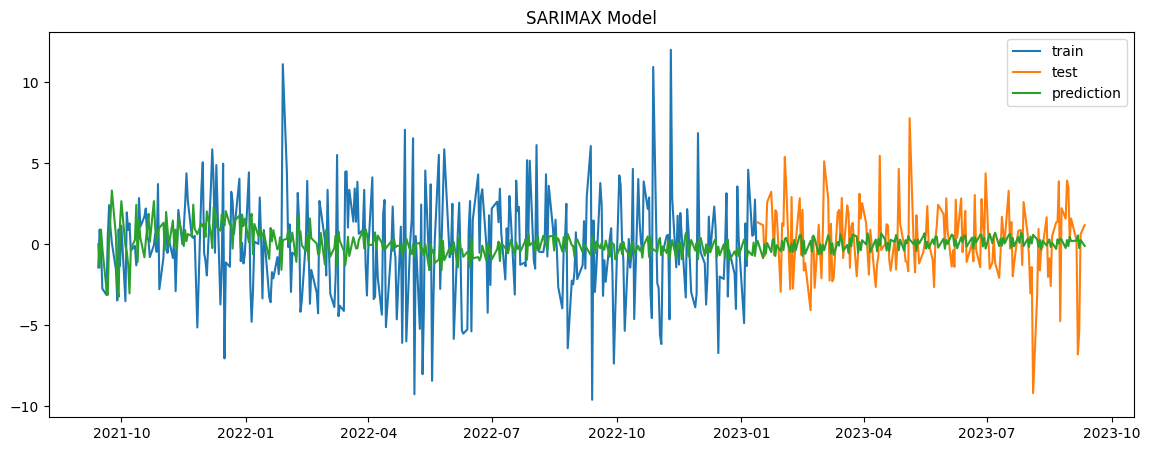

In [124]:
## plotting train against test 
pred = arima_model.get_prediction().predicted_mean

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(train_data['Close'], label='train')
ax.plot(test_data['Close'], label='test')
ax.plot(pred, label='prediction')
plt.legend()
plt.title('SARIMAX Model')
plt.show()

## Forecast Plot

In [119]:
from datetime import datetime, timedelta

today = datetime.today().date()
end_date = today + timedelta(days=30)
date_range = pd.date_range(start=today, end=end_date, freq='D')
test_df = pd.DataFrame(index=date_range)

In [120]:
## plot forecast plot
forecast = arima_model.get_forecast(steps=30)

## confidence intervals
fore_ci = forecast.conf_int()
ax = stationary['Close'].plot(label='observed', figsize=(14, 4))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(fore_ci.index,
                fore_ci.iloc[:, 0],
                fore_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
plt.title("CO Forecast")
plt.show()

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.